1/1 [==============================] - 0s 278ms/step


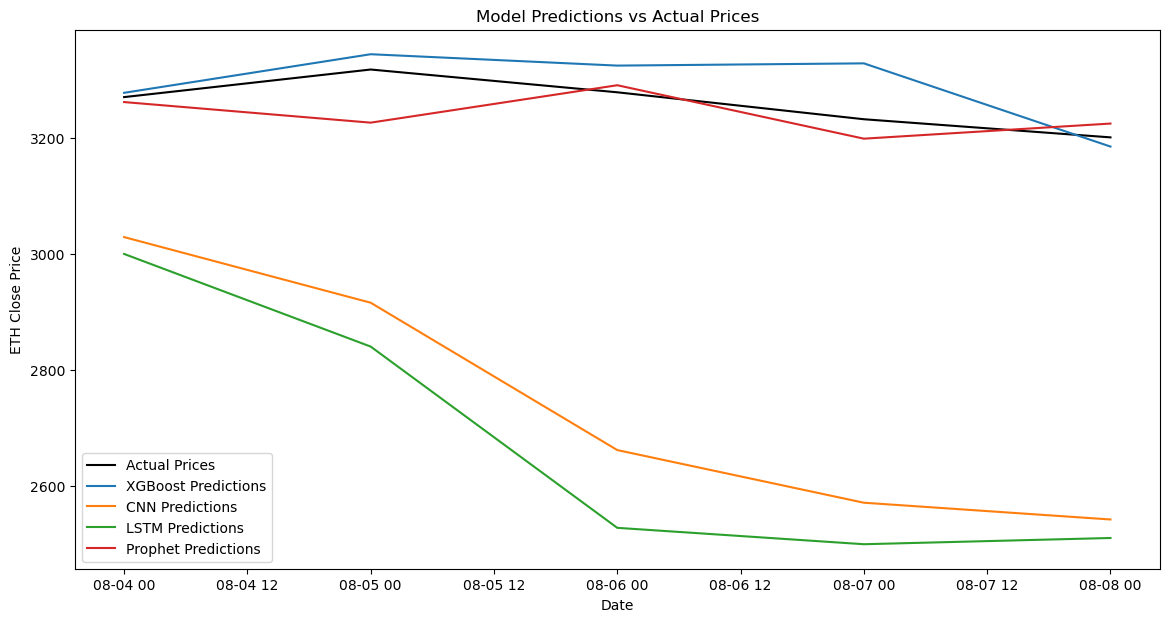

     Model         MAE            MSE          R2
0  XGBoost   38.400258    2480.840891   -0.536147
1      CNN  516.099654  294373.103960 -181.277099
2     LSTM  584.553156  375908.998459 -231.764478
3  Prophet   33.940236    2061.582453   -0.276541


In [7]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import load_model
import seaborn as sns
from prophet import Prophet

# Step 1: Load the New Dataset
file_path = '/Users/noraizabid/Desktop/Checking all models/ETHBTC1DAY.csv'  # Update this with the correct path to your new dataset
data = pd.read_csv(file_path)

# Convert the time column to datetime
data['time'] = pd.to_datetime(data['time'], format='%d/%m/%Y')
data = data.sort_values('time')

# Step 2: Preprocess Data for Each Model

# XGBoost expects lag features
def create_lag_features(data, lags=7):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}_btc_open'] = data['Btc-open'].shift(lag)
        data[f'lag_{lag}_btc_high'] = data['Btc-high'].shift(lag)
        data[f'lag_{lag}_btc_low'] = data['Btc-low'].shift(lag)
        data[f'lag_{lag}_btc_close'] = data['Btc-close'].shift(lag)
        data[f'lag_{lag}_btc_volume'] = data['Btc-volume'].shift(lag)
        data[f'lag_{lag}_eth_open'] = data['Eth-open'].shift(lag)
        data[f'lag_{lag}_eth_high'] = data['Eth-high'].shift(lag)
        data[f'lag_{lag}_eth_low'] = data['Eth-low'].shift(lag)
        data[f'lag_{lag}_eth_volume'] = data['Eth-volume'].shift(lag)
        data[f'lag_{lag}_eth_close'] = data['Eth-close'].shift(lag)
    return data

# Create lag features
data = create_lag_features(data).dropna()

# Prepare data for Prophet
prophet_df = data[['time', 'Eth-close', 'Btc-open', 'Btc-high', 'Btc-low', 'Btc-close', 'Btc-volume', 'Eth-open', 'Eth-high', 'Eth-low', 'Eth-volume']].rename(columns={'time': 'ds', 'Eth-close': 'y'})

# CNN and LSTM require scaled data and sequences with specific features

# CNN Model
cnn_features = [
    'Btc-open', 'Btc-high', 'Btc-low', 'Btc-close', 'Btc-volume',
    'Eth-open', 'Eth-high', 'Eth-low', 'Eth-volume', 'Eth-close'
]

cnn_data = data[cnn_features]
cnn_scaler = MinMaxScaler(feature_range=(0, 1))
cnn_scaled_data = cnn_scaler.fit_transform(cnn_data)

def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(data[i + sequence_length, -1])  # Target is 'Eth-close' price (last column in the scaled data)
    return np.array(sequences), np.array(targets)

SEQ_LENGTH = 7
X_seq_cnn, y_seq_cnn = create_sequences(cnn_scaled_data, SEQ_LENGTH)

# LSTM Model
lstm_features = [
    'Btc-open', 'Btc-high', 'Btc-low', 'Btc-close', 'Eth-close'
]

lstm_data = data[lstm_features]
lstm_scaler = MinMaxScaler(feature_range=(0, 1))
lstm_scaled_data = lstm_scaler.fit_transform(lstm_data)

X_seq_lstm, y_seq_lstm = create_sequences(lstm_scaled_data, SEQ_LENGTH)

# Split the data
train_size = int(len(X_seq_cnn) * 0.75)

X_train_seq_cnn, X_test_seq_cnn = X_seq_cnn[:train_size], X_seq_cnn[train_size:]
y_train_seq_cnn, y_test_seq_cnn = y_seq_cnn[:train_size], y_seq_cnn[train_size:]

X_train_seq_lstm, X_test_seq_lstm = X_seq_lstm[:train_size], X_seq_lstm[train_size:]
y_train_seq_lstm, y_test_seq_lstm = y_seq_lstm[:train_size], y_seq_lstm[train_size:]

# Prepare data for XGBoost
X_xgb = data.drop(columns=['time', 'Eth-close'])
y_xgb = data['Eth-close']
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = X_xgb.iloc[:train_size], X_xgb.iloc[train_size:], y_xgb.iloc[:train_size], y_xgb.iloc[train_size:]

# Step 3: Load the Saved Models
xgb_model = joblib.load('/Users/noraizabid/Desktop/Checking all models/xgboost_model_eth+btc_1d.pkl')
cnn_model = load_model('/Users/noraizabid/Desktop/Checking all models/cnn_model_btc+eth_1d.keras')
lstm_model = load_model('/Users/noraizabid/Desktop/Checking all models/lstm_model_1d_eth_all_features_tuned.keras')
prophet_model = joblib.load('/Users/noraizabid/Desktop/Checking all models/prophet_model_75_percent_training_eth_1d_7days.pkl')

# Step 4: Make Predictions
# XGBoost predictions
y_pred_xgb = xgb_model.predict(X_test_xgb)

# CNN predictions
y_pred_cnn = cnn_model.predict(X_test_seq_cnn)
y_pred_cnn_inv = cnn_scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred_cnn), len(cnn_features)-1)), y_pred_cnn), axis=1))[:, -1]

# LSTM predictions
y_pred_lstm = lstm_model.predict(X_test_seq_lstm)
y_pred_lstm_inv = lstm_scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred_lstm), len(lstm_features)-1)), y_pred_lstm), axis=1))[:, -1]

# Prophet predictions
future = prophet_df[['ds', 'Btc-open', 'Btc-high', 'Btc-low', 'Btc-close', 'Btc-volume', 'Eth-open', 'Eth-high', 'Eth-low', 'Eth-volume']].iloc[train_size:]
forecast = prophet_model.predict(future)
y_pred_prophet = forecast['yhat']

# Step 5: Align Lengths of Data for Plotting
min_length = min(len(y_xgb.iloc[train_size:]), len(y_pred_xgb), len(y_pred_cnn_inv), len(y_pred_lstm_inv), len(y_pred_prophet))

# Align all arrays to the minimum length
test_dates = data['time'].iloc[train_size + SEQ_LENGTH:train_size + SEQ_LENGTH + min_length]
y_xgb_plot = y_xgb.iloc[train_size:train_size + min_length]
y_pred_xgb = y_pred_xgb[:min_length]
y_pred_cnn_inv = y_pred_cnn_inv[:min_length]
y_pred_lstm_inv = y_pred_lstm_inv[:min_length]
y_pred_prophet = y_pred_prophet[:min_length]

# Step 6: Visualization
plt.figure(figsize=(14, 7))

# Actual Prices
plt.plot(test_dates, y_xgb_plot, color='black', label='Actual Prices')

# Predicted Prices by each model
plt.plot(test_dates, y_pred_xgb, label='XGBoost Predictions')
plt.plot(test_dates, y_pred_cnn_inv, label='CNN Predictions')
plt.plot(test_dates, y_pred_lstm_inv, label='LSTM Predictions')
plt.plot(test_dates, y_pred_prophet, label='Prophet Predictions')

plt.title('Model Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('ETH Close Price')
plt.legend()
plt.show()

# Step 7: Evaluate the Models
metrics = {
    'Model': ['XGBoost', 'CNN', 'LSTM', 'Prophet'],
    'MAE': [
        mean_absolute_error(y_xgb_plot, y_pred_xgb),
        mean_absolute_error(y_xgb_plot, y_pred_cnn_inv),
        mean_absolute_error(y_xgb_plot, y_pred_lstm_inv),
        mean_absolute_error(y_xgb_plot, y_pred_prophet)
    ],
    'MSE': [
        mean_squared_error(y_xgb_plot, y_pred_xgb),
        mean_squared_error(y_xgb_plot, y_pred_cnn_inv),
        mean_squared_error(y_xgb_plot, y_pred_lstm_inv),
        mean_squared_error(y_xgb_plot, y_pred_prophet)
    ],
    'R2': [
        r2_score(y_xgb_plot, y_pred_xgb),
        r2_score(y_xgb_plot, y_pred_cnn_inv),
        r2_score(y_xgb_plot, y_pred_lstm_inv),
        r2_score(y_xgb_plot, y_pred_prophet)
    ]
}

# Step 8: Print Evaluation Metrics
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Save the metrics to a CSV file for future reference
metrics_df.to_csv('/Users/noraizabid/Desktop/Checking all models/model_comparison_metrics.csv', index=False)


1/1 [==============================] - 0s 273ms/step


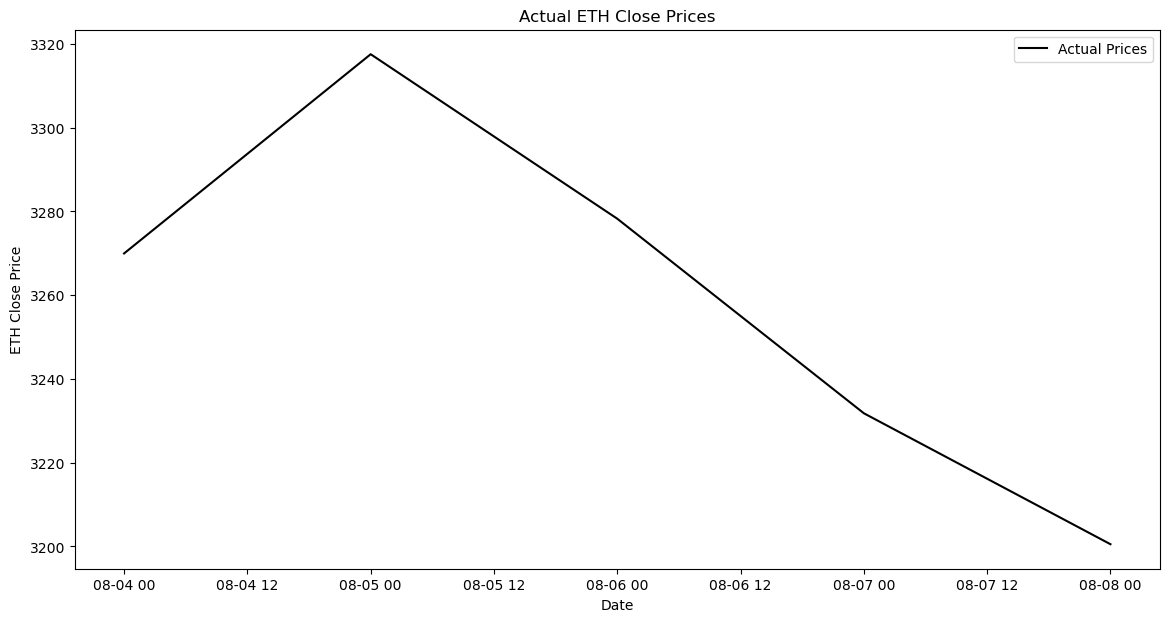

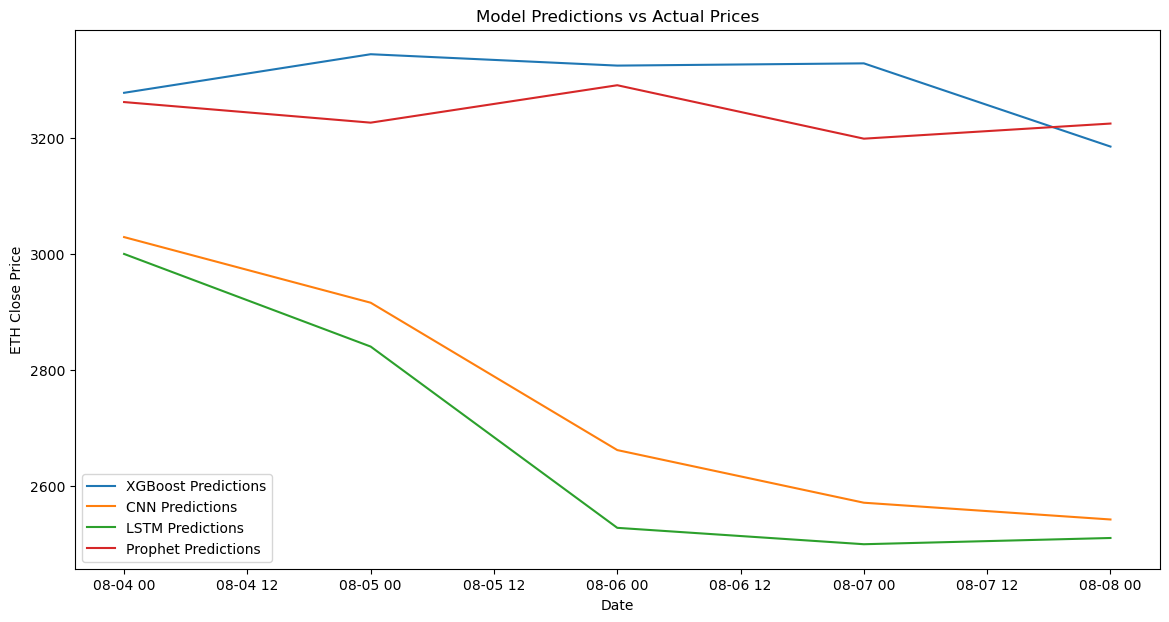

     Model         MAE            MSE          R2
0  XGBoost   38.400258    2480.840891   -0.536147
1      CNN  516.099654  294373.103960 -181.277099
2     LSTM  584.553156  375908.998459 -231.764478
3  Prophet   33.940236    2061.582453   -0.276541


In [9]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import load_model
import seaborn as sns
from prophet import Prophet
from sklearn.model_selection import train_test_split

# Step 1: Load the New Dataset
file_path = '/Users/noraizabid/Desktop/Checking all models/ETHBTC1DAY.csv'  # Update this with the correct path to your new dataset
data = pd.read_csv(file_path)

# Convert the time column to datetime
data['time'] = pd.to_datetime(data['time'], format='%d/%m/%Y')
data = data.sort_values('time')

# Step 2: Preprocess Data for Each Model

# XGBoost expects lag features
def create_lag_features(data, lags=7):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}_btc_open'] = data['Btc-open'].shift(lag)
        data[f'lag_{lag}_btc_high'] = data['Btc-high'].shift(lag)
        data[f'lag_{lag}_btc_low'] = data['Btc-low'].shift(lag)
        data[f'lag_{lag}_btc_close'] = data['Btc-close'].shift(lag)
        data[f'lag_{lag}_btc_volume'] = data['Btc-volume'].shift(lag)
        data[f'lag_{lag}_eth_open'] = data['Eth-open'].shift(lag)
        data[f'lag_{lag}_eth_high'] = data['Eth-high'].shift(lag)
        data[f'lag_{lag}_eth_low'] = data['Eth-low'].shift(lag)
        data[f'lag_{lag}_eth_volume'] = data['Eth-volume'].shift(lag)
        data[f'lag_{lag}_eth_close'] = data['Eth-close'].shift(lag)
    return data

# Create lag features
data = create_lag_features(data).dropna()

# Prepare data for Prophet
prophet_df = data[['time', 'Eth-close', 'Btc-open', 'Btc-high', 'Btc-low', 'Btc-close', 'Btc-volume', 'Eth-open', 'Eth-high', 'Eth-low', 'Eth-volume']].rename(columns={'time': 'ds', 'Eth-close': 'y'})

# CNN and LSTM require scaled data and sequences with specific features

# CNN Model
cnn_features = [
    'Btc-open', 'Btc-high', 'Btc-low', 'Btc-close', 'Btc-volume',
    'Eth-open', 'Eth-high', 'Eth-low', 'Eth-volume', 'Eth-close'
]

cnn_data = data[cnn_features]
cnn_scaler = MinMaxScaler(feature_range=(0, 1))
cnn_scaled_data = cnn_scaler.fit_transform(cnn_data)

def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(data[i + sequence_length, -1])  # Target is 'Eth-close' price (last column in the scaled data)
    return np.array(sequences), np.array(targets)

SEQ_LENGTH = 7
X_seq_cnn, y_seq_cnn = create_sequences(cnn_scaled_data, SEQ_LENGTH)

# LSTM Model
lstm_features = [
    'Btc-open', 'Btc-high', 'Btc-low', 'Btc-close', 'Eth-close'
]

lstm_data = data[lstm_features]
lstm_scaler = MinMaxScaler(feature_range=(0, 1))
lstm_scaled_data = lstm_scaler.fit_transform(lstm_data)

X_seq_lstm, y_seq_lstm = create_sequences(lstm_scaled_data, SEQ_LENGTH)

# Split the data
train_size = int(len(X_seq_cnn) * 0.75)
random_state = 42  # For reproducibility

# Using a consistent split strategy
X_train_seq_cnn, X_test_seq_cnn, y_train_seq_cnn, y_test_seq_cnn = train_test_split(
    X_seq_cnn, y_seq_cnn, train_size=train_size, random_state=random_state, shuffle=False
)

X_train_seq_lstm, X_test_seq_lstm, y_train_seq_lstm, y_test_seq_lstm = train_test_split(
    X_seq_lstm, y_seq_lstm, train_size=train_size, random_state=random_state, shuffle=False
)

# Prepare data for XGBoost
X_xgb = data.drop(columns=['time', 'Eth-close'])
y_xgb = data['Eth-close']
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, train_size=train_size, random_state=random_state, shuffle=False
)

# Step 3: Load the Saved Models
xgb_model = joblib.load('/Users/noraizabid/Desktop/Checking all models/xgboost_model_eth+btc_1d.pkl')
cnn_model = load_model('/Users/noraizabid/Desktop/Checking all models/cnn_model_btc+eth_1d.keras')
lstm_model = load_model('/Users/noraizabid/Desktop/Checking all models/lstm_model_1d_eth_all_features_tuned.keras')
prophet_model = joblib.load('/Users/noraizabid/Desktop/Checking all models/prophet_model_75_percent_training_eth_1d_7days.pkl')

# Step 4: Make Predictions
# XGBoost predictions
y_pred_xgb = xgb_model.predict(X_test_xgb)

# CNN predictions
y_pred_cnn = cnn_model.predict(X_test_seq_cnn)
y_pred_cnn_inv = cnn_scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred_cnn), len(cnn_features)-1)), y_pred_cnn), axis=1))[:, -1]

# LSTM predictions
y_pred_lstm = lstm_model.predict(X_test_seq_lstm)
y_pred_lstm_inv = lstm_scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred_lstm), len(lstm_features)-1)), y_pred_lstm), axis=1))[:, -1]

# Prophet predictions
future = prophet_df[['ds', 'Btc-open', 'Btc-high', 'Btc-low', 'Btc-close', 'Btc-volume', 'Eth-open', 'Eth-high', 'Eth-low', 'Eth-volume']].iloc[train_size:]
forecast = prophet_model.predict(future)
y_pred_prophet = forecast['yhat']

# Step 5: Align Lengths of Data for Plotting
min_length = min(len(y_xgb.iloc[train_size:]), len(y_pred_xgb), len(y_pred_cnn_inv), len(y_pred_lstm_inv), len(y_pred_prophet))

# Align all arrays to the minimum length
test_dates = data['time'].iloc[train_size + SEQ_LENGTH:train_size + SEQ_LENGTH + min_length]
y_xgb_plot = y_xgb.iloc[train_size:train_size + min_length]
y_pred_xgb = y_pred_xgb[:min_length]
y_pred_cnn_inv = y_pred_cnn_inv[:min_length]
y_pred_lstm_inv = y_pred_lstm_inv[:min_length]
y_pred_prophet = y_pred_prophet[:min_length]

# Step 6: Visualization

# Plot Actual Prices
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_xgb_plot, color='black', label='Actual Prices')
plt.title('Actual ETH Close Prices')
plt.xlabel('Date')
plt.ylabel('ETH Close Price')
plt.legend()
plt.show()

# Plot Model Predictions
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_pred_xgb, label='XGBoost Predictions')
plt.plot(test_dates, y_pred_cnn_inv, label='CNN Predictions')
plt.plot(test_dates, y_pred_lstm_inv, label='LSTM Predictions')
plt.plot(test_dates, y_pred_prophet, label='Prophet Predictions')
plt.title('Model Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('ETH Close Price')
plt.legend()
plt.show()

# Step 7: Evaluate the Models
metrics = {
    'Model': ['XGBoost', 'CNN', 'LSTM', 'Prophet'],
    'MAE': [
        mean_absolute_error(y_xgb_plot, y_pred_xgb),
        mean_absolute_error(y_xgb_plot, y_pred_cnn_inv),
        mean_absolute_error(y_xgb_plot, y_pred_lstm_inv),
        mean_absolute_error(y_xgb_plot, y_pred_prophet)
    ],
    'MSE': [
        mean_squared_error(y_xgb_plot, y_pred_xgb),
        mean_squared_error(y_xgb_plot, y_pred_cnn_inv),
        mean_squared_error(y_xgb_plot, y_pred_lstm_inv),
        mean_squared_error(y_xgb_plot, y_pred_prophet)
    ],
    'R2': [
        r2_score(y_xgb_plot, y_pred_xgb),
        r2_score(y_xgb_plot, y_pred_cnn_inv),
        r2_score(y_xgb_plot, y_pred_lstm_inv),
        r2_score(y_xgb_plot, y_pred_prophet)
    ]
}

# Step 8: Print Evaluation Metrics
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Save the metrics to a CSV file for future reference
metrics_df.to_csv('/Users/noraizabid/Desktop/Checking all models/model_comparison_metrics.csv', index=False)


1/1 [==============================] - 0s 256ms/step


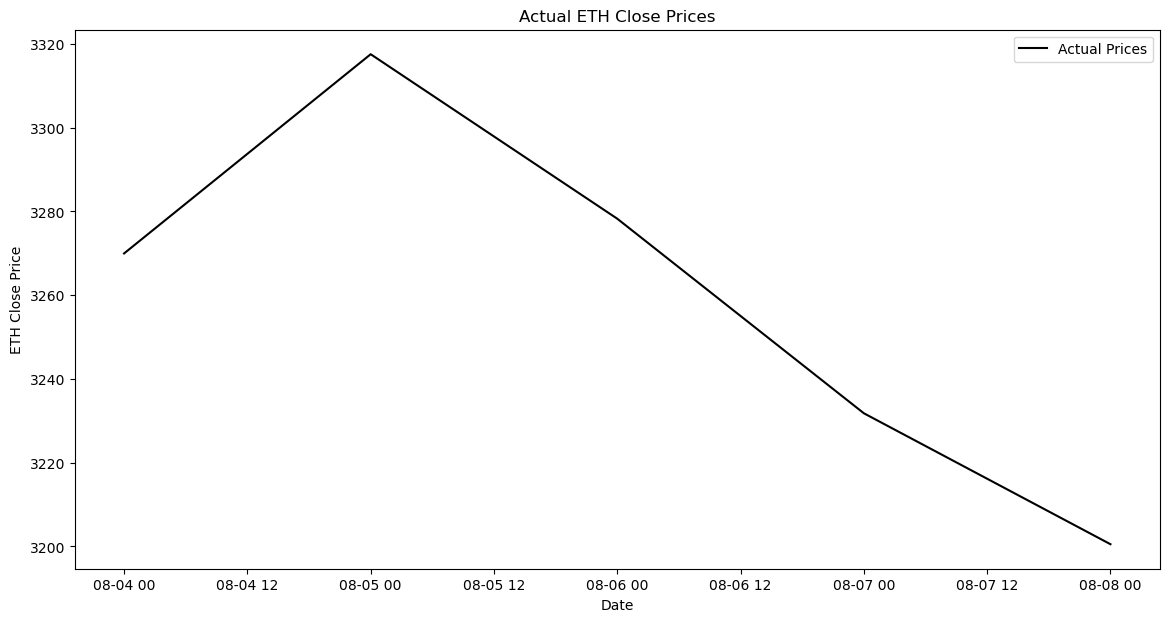

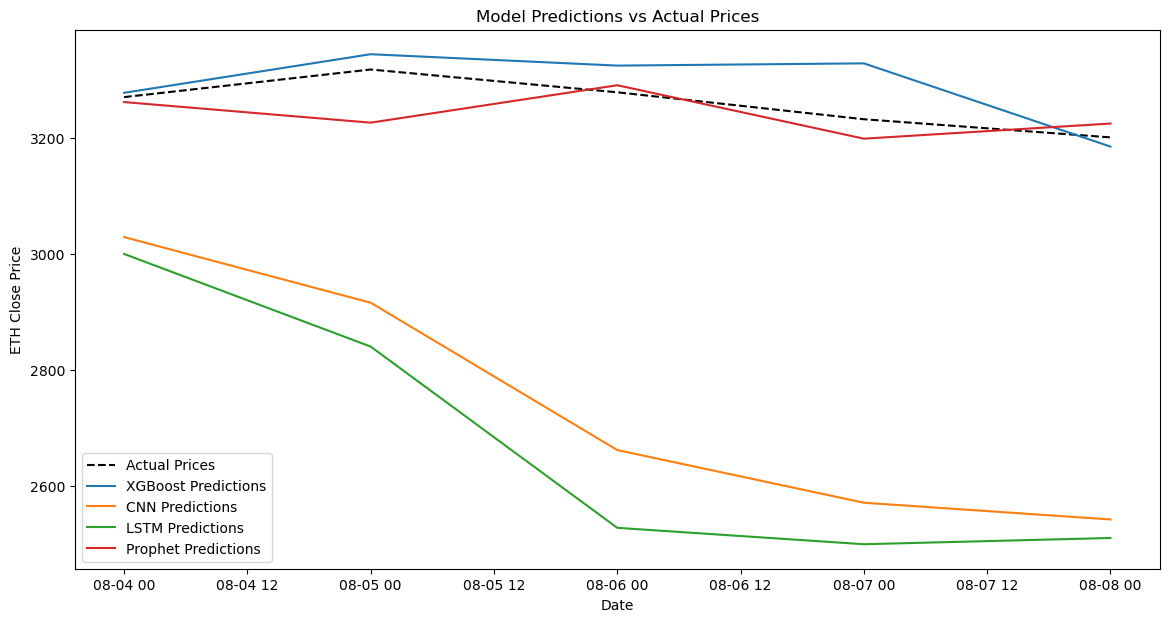

     Model         MAE            MSE          R2
0  XGBoost   38.400258    2480.840891   -0.536147
1      CNN  516.099654  294373.103960 -181.277099
2     LSTM  584.553156  375908.998459 -231.764478
3  Prophet   33.940236    2061.582453   -0.276541


In [11]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import load_model
import seaborn as sns
from prophet import Prophet
from sklearn.model_selection import train_test_split

# Step 1: Load the New Dataset
file_path = '/Users/noraizabid/Desktop/Checking all models/ETHBTC1DAY.csv'  # Update this with the correct path to your new dataset
data = pd.read_csv(file_path)

# Convert the time column to datetime
data['time'] = pd.to_datetime(data['time'], format='%d/%m/%Y')
data = data.sort_values('time')

# Step 2: Preprocess Data for Each Model

# XGBoost expects lag features
def create_lag_features(data, lags=7):
    for lag in range(1, lags + 1):
        data[f'lag_{lag}_btc_open'] = data['Btc-open'].shift(lag)
        data[f'lag_{lag}_btc_high'] = data['Btc-high'].shift(lag)
        data[f'lag_{lag}_btc_low'] = data['Btc-low'].shift(lag)
        data[f'lag_{lag}_btc_close'] = data['Btc-close'].shift(lag)
        data[f'lag_{lag}_btc_volume'] = data['Btc-volume'].shift(lag)
        data[f'lag_{lag}_eth_open'] = data['Eth-open'].shift(lag)
        data[f'lag_{lag}_eth_high'] = data['Eth-high'].shift(lag)
        data[f'lag_{lag}_eth_low'] = data['Eth-low'].shift(lag)
        data[f'lag_{lag}_eth_volume'] = data['Eth-volume'].shift(lag)
        data[f'lag_{lag}_eth_close'] = data['Eth-close'].shift(lag)
    return data

# Create lag features
data = create_lag_features(data).dropna()

# Prepare data for Prophet
prophet_df = data[['time', 'Eth-close', 'Btc-open', 'Btc-high', 'Btc-low', 'Btc-close', 'Btc-volume', 'Eth-open', 'Eth-high', 'Eth-low', 'Eth-volume']].rename(columns={'time': 'ds', 'Eth-close': 'y'})

# CNN and LSTM require scaled data and sequences with specific features

# CNN Model
cnn_features = [
    'Btc-open', 'Btc-high', 'Btc-low', 'Btc-close', 'Btc-volume',
    'Eth-open', 'Eth-high', 'Eth-low', 'Eth-volume', 'Eth-close'
]

cnn_data = data[cnn_features]
cnn_scaler = MinMaxScaler(feature_range=(0, 1))
cnn_scaled_data = cnn_scaler.fit_transform(cnn_data)

def create_sequences(data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i + sequence_length])
        targets.append(data[i + sequence_length, -1])  # Target is 'Eth-close' price (last column in the scaled data)
    return np.array(sequences), np.array(targets)

SEQ_LENGTH = 7
X_seq_cnn, y_seq_cnn = create_sequences(cnn_scaled_data, SEQ_LENGTH)

# LSTM Model
lstm_features = [
    'Btc-open', 'Btc-high', 'Btc-low', 'Btc-close', 'Eth-close'
]

lstm_data = data[lstm_features]
lstm_scaler = MinMaxScaler(feature_range=(0, 1))
lstm_scaled_data = lstm_scaler.fit_transform(lstm_data)

X_seq_lstm, y_seq_lstm = create_sequences(lstm_scaled_data, SEQ_LENGTH)

# Split the data
train_size = int(len(X_seq_cnn) * 0.75)
random_state = 42  # For reproducibility

# Using a consistent split strategy
X_train_seq_cnn, X_test_seq_cnn, y_train_seq_cnn, y_test_seq_cnn = train_test_split(
    X_seq_cnn, y_seq_cnn, train_size=train_size, random_state=random_state, shuffle=False
)

X_train_seq_lstm, X_test_seq_lstm, y_train_seq_lstm, y_test_seq_lstm = train_test_split(
    X_seq_lstm, y_seq_lstm, train_size=train_size, random_state=random_state, shuffle=False
)

# Prepare data for XGBoost
X_xgb = data.drop(columns=['time', 'Eth-close'])
y_xgb = data['Eth-close']
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(
    X_xgb, y_xgb, train_size=train_size, random_state=random_state, shuffle=False
)

# Step 3: Load the Saved Models
xgb_model = joblib.load('/Users/noraizabid/Desktop/Checking all models/xgboost_model_eth+btc_1d.pkl')
cnn_model = load_model('/Users/noraizabid/Desktop/Checking all models/cnn_model_btc+eth_1d.keras')
lstm_model = load_model('/Users/noraizabid/Desktop/Checking all models/lstm_model_1d_eth_all_features_tuned.keras')
prophet_model = joblib.load('/Users/noraizabid/Desktop/Checking all models/prophet_model_75_percent_training_eth_1d_7days.pkl')

# Step 4: Make Predictions
# XGBoost predictions
y_pred_xgb = xgb_model.predict(X_test_xgb)

# CNN predictions
y_pred_cnn = cnn_model.predict(X_test_seq_cnn)
y_pred_cnn_inv = cnn_scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred_cnn), len(cnn_features)-1)), y_pred_cnn), axis=1))[:, -1]

# LSTM predictions
y_pred_lstm = lstm_model.predict(X_test_seq_lstm)
y_pred_lstm_inv = lstm_scaler.inverse_transform(np.concatenate((np.zeros((len(y_pred_lstm), len(lstm_features)-1)), y_pred_lstm), axis=1))[:, -1]

# Prophet predictions
future = prophet_df[['ds', 'Btc-open', 'Btc-high', 'Btc-low', 'Btc-close', 'Btc-volume', 'Eth-open', 'Eth-high', 'Eth-low', 'Eth-volume']].iloc[train_size:]
forecast = prophet_model.predict(future)
y_pred_prophet = forecast['yhat']

# Step 5: Align Lengths of Data for Plotting
min_length = min(len(y_xgb.iloc[train_size:]), len(y_pred_xgb), len(y_pred_cnn_inv), len(y_pred_lstm_inv), len(y_pred_prophet))

# Align all arrays to the minimum length
test_dates = data['time'].iloc[train_size + SEQ_LENGTH:train_size + SEQ_LENGTH + min_length]
y_xgb_plot = y_xgb.iloc[train_size:train_size + min_length]
y_pred_xgb = y_pred_xgb[:min_length]
y_pred_cnn_inv = y_pred_cnn_inv[:min_length]
y_pred_lstm_inv = y_pred_lstm_inv[:min_length]
y_pred_prophet = y_pred_prophet[:min_length]

# Step 6: Visualization

# Plot Actual Prices
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_xgb_plot, color='black', label='Actual Prices')
plt.title('Actual ETH Close Prices')
plt.xlabel('Date')
plt.ylabel('ETH Close Price')
plt.legend()
plt.show()

# Plot Predictions from All Models
plt.figure(figsize=(14, 7))
plt.plot(test_dates, y_xgb_plot, color='black', linestyle='--', label='Actual Prices')
plt.plot(test_dates, y_pred_xgb, label='XGBoost Predictions')
plt.plot(test_dates, y_pred_cnn_inv, label='CNN Predictions')
plt.plot(test_dates, y_pred_lstm_inv, label='LSTM Predictions')
plt.plot(test_dates, y_pred_prophet, label='Prophet Predictions')
plt.title('Model Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('ETH Close Price')
plt.legend()
plt.show()

# Step 7: Evaluate the Models
metrics = {
    'Model': ['XGBoost', 'CNN', 'LSTM', 'Prophet'],
    'MAE': [
        mean_absolute_error(y_xgb_plot, y_pred_xgb),
        mean_absolute_error(y_xgb_plot, y_pred_cnn_inv),
        mean_absolute_error(y_xgb_plot, y_pred_lstm_inv),
        mean_absolute_error(y_xgb_plot, y_pred_prophet)
    ],
    'MSE': [
        mean_squared_error(y_xgb_plot, y_pred_xgb),
        mean_squared_error(y_xgb_plot, y_pred_cnn_inv),
        mean_squared_error(y_xgb_plot, y_pred_lstm_inv),
        mean_squared_error(y_xgb_plot, y_pred_prophet)
    ],
    'R2': [
        r2_score(y_xgb_plot, y_pred_xgb),
        r2_score(y_xgb_plot, y_pred_cnn_inv),
        r2_score(y_xgb_plot, y_pred_lstm_inv),
        r2_score(y_xgb_plot, y_pred_prophet)
    ]
}

# Step 8: Print Evaluation Metrics
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Save the metrics to a CSV file for future reference
metrics_df.to_csv('/Users/noraizabid/Desktop/Checking all models/model_comparison_metrics.csv', index=False)


In [13]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
grid_search.fit(X_train_xgb, y_train_xgb)

best_xgb_model = grid_search.best_estimator_
print(f"Best XGBoost Parameters: {grid_search.best_params_}")


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best XGBoost Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
